# BillSum Summarization

## Load Dependencies

In [ ]:
# !pip uninstall -y flash-attn fsspec gcsfs transformers torch torchvision torchaudio
# !pip install -q -U transformers accelerate bitsandbytes torch torchvision torchaudio datasets==2.14.6 fsspec==2023.9.2
# !pip install -q -U rouge_score evaluate
# !pip install -U sentence-transformers
# !pip install bert_score

Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
Found existing installation: transformers 4.53.2
Uninstalling transformers-4.53.2:
  Successfully uninstalled transformers-4.53.2
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 19.4 MB/s

In [1]:
import datasets
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration, AutoConfig
import evaluate
from tqdm import tqdm
import torch
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

## Load BillSum Dataset

In [2]:
billsum_train = datasets.load_dataset("json", data_files="billsum_data/us_train_data_final_OFFICIAL.jsonl")["train"]
billsum_test = datasets.load_dataset("json", data_files="billsum_data/us_test_data_final_OFFICIAL.jsonl")["train"]

billsum_test

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'summary', 'bill_id', 'title', 'text_len', 'sum_len'],
    num_rows: 3269
})

# Text Separation and Splitting

The following functions split a bill into its main numbered sections and then further splits them based off of each lettered subsection. We are not splitting by each sentence because the text formmatting makes it difficult to split it that way.

In [3]:
def split_bill_into_sections(text):
    # Normalize line breaks
    text = re.sub(r'\n+', '\n', text)

    # Ensure section headers start on a new line (case-insensitive)
    text = re.sub(r'(?<!\n)((SECTION|SEC)\.?\s*\d+\.)', r'\n\1', text, flags=re.IGNORECASE)

    # Match from each SECTION/SEC until the next one or end of text
    pattern = r'((?:SEC|SECTION)\.?\s*\d+\..*?)(?=(?:SEC|SECTION)\.?\s*\d+\.|\Z)'
    sections = re.findall(pattern, text, flags=re.DOTALL | re.IGNORECASE)

    if len(sections) == 0:
        return [text]

    return sections


def split_by_lettered_clause_with_linebreaks(text):
    # Insert a unique delimiter before (a), (b), ... only if they occur after a line break and spaces
    pattern = r'\n[ \t]*\([a-z]\)(?!\([a-zA-Z0-9]\))'
    split_text = re.split(f'({pattern})', text)

    # Recombine so that each clause includes its clause marker
    combined = []
    buffer = ''
    for part in split_text:
        if re.match(pattern, part):
            if buffer:
                combined.append(buffer.strip())
            buffer = part.lstrip('\n')
        else:
            buffer += part
    if buffer:
        combined.append(buffer.strip())

    res = [clause for clause in combined if clause]
    if res == []:
        return [text]
    return res


# Helper function for splitting the bill into subsections
def split_bill(text):
    sections = split_bill_into_sections(text)
    nested_list = [split_by_lettered_clause_with_linebreaks(section) for section in sections]
    flat_list = [item for sublist in nested_list for item in sublist]
    return list(dict.fromkeys(flat_list)) # Prevent duplicates

Below, we will check the average sentence length for each summary to determine the number of sentences to return in our extraction model.

In [4]:
def count_sentences(paragraph):
    # Split the paragraph into sentences using regex for '.', '!' or '?'
    sentences = re.split(r'[.!?]+', paragraph)
    # Remove empty strings and strip whitespace
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

In [5]:
# Get average sentence length
total = 0
for paragraph in billsum_test["summary"]:
    total += count_sentences(paragraph)

total / len(billsum_test["summary"])

5.599877638421535

# Cluster Based Extraction

Below is a function for cluster based extraction. For the vectorization of our sentences we are using tfidf.

In [6]:
def cluster_based_summary(sentences, num_clusters=3):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)

    # Find closest sentence to each cluster centroid
    summary_sentences = []
    for i in range(num_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_vectors = X[cluster_indices].toarray()

        # Compute distances to centroid
        distances = np.linalg.norm(cluster_vectors - cluster_center, axis=1)
        closest_index = cluster_indices[np.argmin(distances)]
        summary_sentences.append(sentences[closest_index])

    # Sort by original order
    summary_sentences.sort(key=lambda s: sentences.index(s))

    return summary_sentences

Below we perform cluster based extraction on the first bill in the test dataset. We split the bill into subsections as mentioned above and defined eight cluters. The result is an eight sentence summary of the bill.

In [7]:
# Example
test_split = split_bill(billsum_test[0]["text"])
cluster_based_summary(test_split, 6)

["(b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''.",
 "SEC. 2. UPPER MISSISSIPPI RIVER ENVIRONMENTAL MANAGEMENT PROGRAM.\n    Section 1103(e)(5) of the Water Resources Development Act of 1986 \n(33 U.S.C. 652(e)(5)) (as amended by section 509(c)(3) of the Water \nResources Development Act of 1999 (113 Stat. 340)) is amended by \nstriking ``paragraph (1)(A)(i)'' and inserting ``paragraph (1)(B)''.",
 'SEC. 8. CONTINUATION OF SUBMISSION OF CERTAIN REPORTS BY THE SECRETARY \n              OF THE ARMY.',
 "(d) List of Authorized but Unfunded Projects.--Section 1001(b)(2) \nof the Water Resources Development Act of 1986 (33 U.S.C. 579a(b)(2)) \nis amended in the first sentence by striking ``Every'' and inserting \n``Notwithstanding section 3003 of Public Law 104-66 (31 U.S.C. 1113 \nnote; 109 Stat. 734), every''.",
 '(a) Program Authoriza

The below function performs cluster based extraction on a list of paragraphs with a set number of clusters, returning a list of summaries.

In [8]:
def do_cluster_based_summary(paragraphs, num_clusters=3):
    res = []
    for i in tqdm(range(len(paragraphs))):
        paragraph = paragraphs[i]
        split = split_bill(paragraph)

        if len(split) < num_clusters:
            summary = cluster_based_summary(split, len(split))
        elif len(split) == num_clusters:
            summary = split
        else:
            summary = cluster_based_summary(split, num_clusters)

        processed_summary = " ".join(summary)
        res.append(processed_summary)

    return res

In [9]:
billsum_test_list = [bill["text"] for bill in billsum_test]

test_cluster = do_cluster_based_summary(billsum_test_list, 6)
test_cluster[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [01:34<00:00, 34.61it/s]


"(b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''. SEC. 2. UPPER MISSISSIPPI RIVER ENVIRONMENTAL MANAGEMENT PROGRAM.\n    Section 1103(e)(5) of the Water Resources Development Act of 1986 \n(33 U.S.C. 652(e)(5)) (as amended by section 509(c)(3) of the Water \nResources Development Act of 1999 (113 Stat. 340)) is amended by \nstriking ``paragraph (1)(A)(i)'' and inserting ``paragraph (1)(B)''. SEC. 8. CONTINUATION OF SUBMISSION OF CERTAIN REPORTS BY THE SECRETARY \n              OF THE ARMY. (d) List of Authorized but Unfunded Projects.--Section 1001(b)(2) \nof the Water Resources Development Act of 1986 (33 U.S.C. 579a(b)(2)) \nis amended in the first sentence by striking ``Every'' and inserting \n``Notwithstanding section 3003 of Public Law 104-66 (31 U.S.C. 1113 \nnote; 109 Stat. 734), every''. (a) Program Authorization.--The progra

# Evaluation



Below is code to calculate the ROUGE score.

In [11]:
rouge = evaluate.load('rouge')

predictions = test_cluster
references = [bill["summary"] for bill in billsum_test]

results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': 0.31373896904632814, 'rouge2': 0.17246760139196612, 'rougeL': 0.2114073775751239, 'rougeLsum': 0.27718205546153235}


Below is code to calculate the BERTScore. We calculate on the first 100 bills because collab runs out of RAM and crashes.

In [12]:
bertscore = evaluate.load("bertscore")

predictions = test_cluster
references = [bill["summary"] for bill in billsum_test]

results = bertscore.compute(predictions=predictions, references=references, lang="en")
# print(results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7324097658669632
Average recall: 0.8399468681505238
Average f1: 0.7817269063900282


# Maximal Marginal Relevance

Below is a function for maximal marginal relevance. For the vectorization of our sentences we are using tfidf.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def mmr_summary(sentences, top_n=3, lambda_param=0.7):
    vectorizer = TfidfVectorizer(stop_words='english')
    sentence_vectors = vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(sentence_vectors)

    selected_indices = [0]  # Start with the first sentence
    candidates = list(range(1, len(sentences)))

    while len(selected_indices) < top_n and candidates:
        mmr_scores = []

        for idx in candidates:
            relevance = similarity_matrix[0][idx]  # relevance to first sentence (or centroid)
            redundancy = max(similarity_matrix[idx][j] for j in selected_indices)

            mmr_score = lambda_param * relevance - (1 - lambda_param) * redundancy
            mmr_scores.append((idx, mmr_score))

        # Select the index with the highest MMR score
        best_idx = max(mmr_scores, key=lambda x: x[1])[0]
        selected_indices.append(best_idx)
        candidates.remove(best_idx)

    return [sentences[i] for i in selected_indices]

The below function performs mmr summarization on a list of paragraphs with a set number for top_n, returning a list of summaries.

In [15]:
def do_mmr_summary(paragraphs, top_n=3, lambda_param=0.7):
    res = []
    for i in tqdm(range(len(paragraphs))):
        paragraph = paragraphs[i]
        split = split_bill(paragraph)

        if len(split) < top_n:
            summary = mmr_summary(split, len(split), lambda_param)
        else:
            summary = mmr_summary(split, top_n, lambda_param)

        processed_summary = " ".join(summary)
        res.append(processed_summary)

    return res

In [16]:
billsum_test_list = [bill["text"] for bill in billsum_test]

test_mmr = do_mmr_summary(billsum_test_list, 6, 0.7)
test_mmr[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [00:09<00:00, 339.65it/s]


"SECTION 1. ENVIRONMENTAL INFRASTRUCTURE. SEC. 2. UPPER MISSISSIPPI RIVER ENVIRONMENTAL MANAGEMENT PROGRAM.\n    Section 1103(e)(5) of the Water Resources Development Act of 1986 \n(33 U.S.C. 652(e)(5)) (as amended by section 509(c)(3) of the Water \nResources Development Act of 1999 (113 Stat. 340)) is amended by \nstriking ``paragraph (1)(A)(i)'' and inserting ``paragraph (1)(B)''. (b) Authorization of Appropriations.--Funds are hereby authorized \nto be appropriated for the Department of Transportation for the program \nauthorized in subsection (a) in amounts as follows:\n        (1) Fiscal year 2000.--For fiscal year 2000, $10,000,000.\n        (2) Fiscal year 2001.--For fiscal year 2001, $10,000,000.\n        (3) Fiscal year 2002.--For fiscal year 2002, $7,000,000. SEC. 8. CONTINUATION OF SUBMISSION OF CERTAIN REPORTS BY THE SECRETARY \n              OF THE ARMY. (c) Applicability.--The program referred to in subsection (a) is \nthe program for which funds appropriated in title I 

# Evaluation

Below is code to calculate the ROUGE score.

In [17]:
rouge = evaluate.load('rouge')

predictions = test_mmr
references = [bill["summary"] for bill in billsum_test]

results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': 0.31172476851354347, 'rouge2': 0.17299389058044898, 'rougeL': 0.2010153291960229, 'rougeLsum': 0.27513832998368126}


Below is code to calculate the BERTScore. We calculate on the first 100 bills because collab runs out of RAM and crashes.

In [18]:
bertscore = evaluate.load("bertscore")

predictions = test_mmr
references = [bill["summary"] for bill in billsum_test]

results = bertscore.compute(predictions=predictions, references=references, lang="en")
# print(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7367173106563167
Average recall: 0.8406769576769935
Average f1: 0.7844733007641953


# Hybrid Cluster Extraction + PEGASUS

The below function creates a dataset with shortened bills using MMR summarization, to avoid truncation when the bills get passed through PEGASUS.

In [34]:
def get_mmr_summary_as_dataset(dataset, top_n=3, lambda_param=0.7):
    titles = [bill["title"] for bill in dataset]
    sentences = [bill["text"] for bill in dataset]
    summaries = [bill["summary"] for bill in dataset]

    cluster_summaries = do_mmr_summary(sentences, top_n, lambda_param)

    res = {"text": cluster_summaries, "summary": summaries, "title": titles}
    return datasets.Dataset.from_dict(res)

In [35]:
# shortened_billsum_train = get_mmr_summary_as_dataset(billsum_train, 6)
shortened_billsum_test = get_mmr_summary_as_dataset(billsum_test, 6)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [00:09<00:00, 355.68it/s]


In [36]:
shortened_billsum_test.to_json("billsum_test_mmr.jsonl")

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

21301132

### Check Max Sequence Length

PEGASUS has a maximum sequence length of 1028. We can tokenize a subset of the training data to check how many documents will be truncated.

In [22]:
model_name = "google/pegasus-cnn_dailymail"

tokenizer = PegasusTokenizer.from_pretrained(model_name, from_pt=True)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [23]:
text_lengths = []
for record in tqdm(shortened_billsum_train):
    text_lengths.append(len(tokenizer(record["text"]).input_ids))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.82it/s]


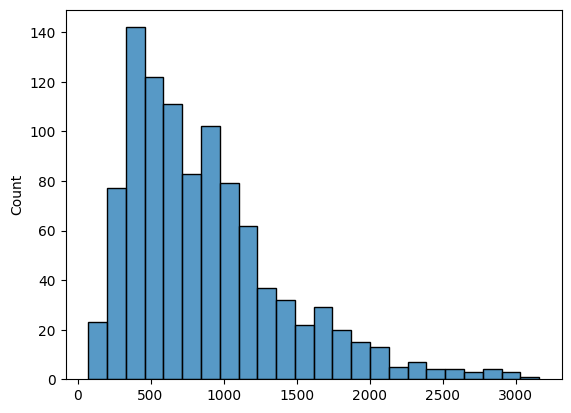

In [24]:
sns.histplot(x = text_lengths)

plt.show()

## Load PEGASUS Model

In [27]:
model = TFPegasusForConditionalGeneration.from_pretrained(model_name, from_pt=True)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.summary()

Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  570797056 
                                                                 
 final_logits_bias (BiasLaye  multiple                 96103     
 r)                                                              
                                                                 
Total params: 570,893,159
Trainable params: 570,797,056
Non-trainable params: 96,103
_________________________________________________________________


## Test Base PEGASUS Without Fine Tuning

Below we create a dataset of the first 5 documents in the shortened billsum dataset, due to our compute limitations on Colab.

In [29]:
mini_billsum_test = {"text": shortened_billsum_test["text"], "summary": shortened_billsum_test["summary"]}
mini_billsum_test = datasets.Dataset.from_dict(mini_billsum_test)

In [32]:
def process_batch(batch):
    inputs = tokenizer(batch["text"], truncation = True, padding = "longest", return_tensors = "tf")
    return inputs, batch["summary"]

def generate_summaries(data, batch_size = 16):
    generated_summaries = []

    for i in tqdm(range(0, len(data), batch_size)):
        inputs, targets = process_batch(data[i:i+batch_size])

        output = model.generate(
          input_ids=inputs["input_ids"],
          attention_mask=inputs["attention_mask"],
          max_length=512,         # Increase as needed, up to model limits
          min_length=128,
          length_penalty=0.5,     # Lower value encourages longer output
          num_beams=4,
          early_stopping=True,
          repetition_penalty=1.2,        # <--- Penalizes repeating tokens
          no_repeat_ngram_size=3,
        )



        generated_summaries += tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return generated_summaries

In [33]:
test_summaries_base = generate_summaries(mini_billsum_test, 32)

  0%|                                                                                                                                                           | 0/103 [00:00<?, ?it/s]TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
2025-07-22 01:29:03.352954: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.00MiB (rounded to 536870912)requested by op GatherV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-07-22 01:29:03.353595: W tensorflow/core/common_runtime/bfc_allocator.cc:491] ****************************************************************************************************
2025-07-22 01:29:03.353637: W tensorflow/core/framework/op_ker

ResourceExhaustedError: OOM when allocating tensor with shape[32,4,16,1024,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:GatherV2]

In [ ]:
test_summaries_base

Below we calcualate the ROUGE score.

In [ ]:
rouge = evaluate.load('rouge')

predictions = test_summaries_base
references = [bill["summary"] for bill in billsum_test][:5]

results = rouge.compute(predictions=predictions, references=references)
print(results)

Below is code to calculate the BERTScore.

In [ ]:
bertscore = evaluate.load("bertscore")

predictions = test_summaries_base # first 100 summaries
references = [bill["summary"] for bill in billsum_test][:5]

results = bertscore.compute(predictions=predictions, references=references, lang="en")
print(results)

In [ ]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')